<a href="https://colab.research.google.com/github/cinnaavox/favorita_sales_forecasting/blob/main/Week_2_3_modeling_and_evaluation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🧱 Block 0 — Setup (ruhigstellen, Pfade, Imports)

In [30]:
!pip -q install --upgrade --no-cache-dir \
  numpy==2.0.2 \
  pandas==2.2.2 \
  scikit-learn==1.6.1 \
  xgboost==2.1.1 \
  mlflow==3.1.1 \
  pyarrow==18.1.0

In [35]:
# 🆘 Rescue-Block — Stelle sicher, dass das Q1-Parquet existiert (finde oder baue es nach)

import os, io, json, gc, glob, math, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

BASE = "/content/drive/MyDrive/time_series_course_guayas"
PARQUET = f"{BASE}/guayas_Q1_2014_ml_ready_favorita.parquet"
SAMPLE  = f"{BASE}/sample_q1_small.csv"
os.makedirs(BASE, exist_ok=True)

def find_any():
    hits = []
    for pat in [
        "/content/drive/**/guayas_Q1_2014_ml_ready_favorita.parquet",
        "/content/drive/**/df_prepared_guayas_favorita.csv",
        "/content/drive/**/sample_q1_small.csv",
    ]:
        hits += glob.glob(pat, recursive=True)
    return hits

print("🔎 Suche vorhandene Artefakte …")
found = find_any()
print("Gefunden:", found[:5], ("… (+ mehr)" if len(found)>5 else ""))

if os.path.exists(PARQUET):
    print("✅ Q1-Parquet vorhanden →", PARQUET)
else:
    # Versuche, eine alternative Quelle zu nehmen
    alt_pq = next((p for p in found if p.endswith(".parquet")), None)
    alt_csv= next((p for p in found if p.endswith("df_prepared_guayas_favorita.csv")), None)
    alt_smp= next((p for p in found if p.endswith("sample_q1_small.csv")), None)

    if alt_pq:
        print("↪️ Kopiere gefundene Parquet nach Zielpfad …")
        pd.read_parquet(alt_pq)  # smoke
        os.system(f'cp "{alt_pq}" "{PARQUET}"')
        print("✅ Kopiert →", PARQUET)

    elif alt_csv:
        print("↪️ Baue Q1-Parquet aus gefundener Week-1 CSV:", alt_csv)
        usecols = ["date","store_nbr","item_nbr","unit_sales"]
        df = pd.read_csv(alt_csv, usecols=usecols, low_memory=False)
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        df = df[(df["date"] >= "2014-01-01") & (df["date"] < "2014-04-01")].copy()

        # einfache Lags/Rollings (wie Week-1 Export hatte)
        def add_lag_roll(g):
            g = g.sort_values("date")
            y = g["unit_sales"]
            g["lag_1"]  = y.shift(1)
            g["lag_7"]  = y.shift(7)
            g["lag_14"] = y.shift(14)
            g["lag_30"] = y.shift(30)
            g["roll_mean_7"] = y.shift(1).rolling(7).mean()
            g["roll_std_7"]  = y.shift(1).rolling(7).std()
            return g
        df = df.groupby(["store_nbr","item_nbr"], group_keys=False).apply(add_lag_roll)

        # Kalenderfeatures + Zyklisch
        df["day_of_week"] = df["date"].dt.dayofweek
        df["month"]       = df["date"].dt.month
        df["dow_sin"] = np.sin(2*np.pi*df["day_of_week"]/7)
        df["dow_cos"] = np.cos(2*np.pi*df["day_of_week"]/7)
        df["mon_sin"] = np.sin(2*np.pi*df["month"]/12)
        df["mon_cos"] = np.cos(2*np.pi*df["month"]/12)

        # robust casten
        df["store_nbr"] = df["store_nbr"].astype("int32")
        df["item_nbr"]  = df["item_nbr"].astype("int32")
        df["unit_sales"]= pd.to_numeric(df["unit_sales"], errors="coerce").astype("float32")

        df.to_parquet(PARQUET, index=False)
        print("✅ Q1-Parquet neu gebaut →", PARQUET, "| rows:", len(df))

    elif alt_smp:
        print("↪️ Nutze kleines Sample als temporäre Quelle:", alt_smp)
        # Kopiere als Zwischenlösung (damit Notebook weiterläuft)
        df = pd.read_csv(alt_smp)
        df.to_parquet(PARQUET, index=False)
        print("✅ Sample→Parquet gespiegelt →", PARQUET, "| rows:", len(df))

    else:
        print("🛠️ Nichts gefunden — baue Q1-Parquet frisch aus den Originalquellen (wie Week-1).")
        # ——— Mini-Rebuild wie Week-1 (Favorita) ———
        # kleine Meta-CSV laden
        !pip -q install gdown
        import gdown, requests

        file_ids = {
            "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
            "items":          "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
            "oil":            "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
            "stores":         "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
            "transactions":   "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_",
            "train":          "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
        }
        def make_url(fid): return f"https://drive.google.com/uc?id={fid}"

        # kleine Tabellen
        df_stores = pd.read_csv(make_url(file_ids["stores"]))
        df_oil    = pd.read_csv(make_url(file_ids["oil"]))
        df_trans  = pd.read_csv(make_url(file_ids["transactions"]))
        for _df,col in [(df_oil,"date"),(df_trans,"date")]:
            _df[col] = pd.to_datetime(_df[col], errors="coerce")
        df_oil["dcoilwtico"] = pd.to_numeric(df_oil["dcoilwtico"], errors="coerce").interpolate().ffill().bfill()

        # Guayas-Store-IDs
        guayas_ids = df_stores.loc[df_stores["state"].astype(str).str.upper().str.strip()=="GUAYAS","store_nbr"].unique()

        # train.csv holen (wie Week-1)
        TRAIN_PATH = "/content/train.csv"
        if not os.path.exists(TRAIN_PATH):
            print("⬇️ Lade train.csv (einmalig, ~5GB) …")
            gdown.download(make_url(file_ids["train"]), TRAIN_PATH, quiet=False)

        # chunk-weise extrahieren: nur benötigte Spalten, Guayas & Q1/2014
        use_cols = ["date","store_nbr","item_nbr","unit_sales","onpromotion"]
        keep = []
        q1_start, q1_end = pd.Timestamp("2014-01-01"), pd.Timestamp("2014-04-01")
        for i,chunk in enumerate(pd.read_csv(TRAIN_PATH, chunksize=10**6, usecols=use_cols, low_memory=False)):
            chunk["date"] = pd.to_datetime(chunk["date"], errors="coerce")
            m = (chunk["store_nbr"].isin(guayas_ids)) & (chunk["date"]>=q1_start) & (chunk["date"]<q1_end)
            sub = chunk.loc[m].copy()
            if len(sub):
                keep.append(sub)
            del chunk, sub
            if (i+1) % 25 == 0:
                print(f"… {i+1} Chunks gescannt")
        if not keep:
            raise RuntimeError("Q1/2014 Guayas nicht in train.csv gefunden – bitte prüfe train.csv.")

        df = pd.concat(keep, ignore_index=True); del keep; gc.collect()

        # Features wie in Week-1 Q1-Export
        def add_lag_roll(g):
            g = g.sort_values("date")
            y = g["unit_sales"]
            g["lag_1"]  = y.shift(1)
            g["lag_7"]  = y.shift(7)
            g["lag_14"] = y.shift(14)
            g["lag_30"] = y.shift(30)
            g["roll_mean_7"] = y.shift(1).rolling(7).mean()
            g["roll_std_7"]  = y.shift(1).rolling(7).std()
            return g
        df = df.groupby(["store_nbr","item_nbr"], group_keys=False).apply(add_lag_roll)

        # Kalender + zyklisch
        df["day_of_week"] = df["date"].dt.dayofweek
        df["month"]       = df["date"].dt.month
        df["dow_sin"] = np.sin(2*np.pi*df["day_of_week"]/7)
        df["dow_cos"] = np.cos(2*np.pi*df["day_of_week"]/7)
        df["mon_sin"] = np.sin(2*np.pi*df["month"]/12)
        df["mon_cos"] = np.cos(2*np.pi*df["month"]/12)

        # Oil & Transactions mergen
        oil = df_oil.rename(columns={"date":"date"}).copy()
        df = df.merge(oil[["date","dcoilwtico"]], on="date", how="left")
        tx = (df_trans.groupby(["store_nbr","date"])["transactions"].sum().reset_index())
        df = df.merge(tx, on=["store_nbr","date"], how="left")

        # onpromotion -> int
        if "onpromotion" in df.columns:
            df["onpromotion"] = (
                df["onpromotion"].astype(str).str.lower()
                .map({"true":1,"false":0,"1":1,"0":0}).fillna(0).astype(int)
            )

        # Casts
        df["store_nbr"] = df["store_nbr"].astype("int32")
        df["item_nbr"]  = df["item_nbr"].astype("int32")
        df["unit_sales"]= pd.to_numeric(df["unit_sales"], errors="coerce").astype("float32")

        # schreiben
        df.to_parquet(PARQUET, index=False)
        print("✅ Q1-Parquet gebaut →", PARQUET, "| rows:", len(df))

# Endkontrolle (Mini)
assert os.path.exists(PARQUET), "Parquet fehlt weiterhin – bitte Output oben prüfen."
df_chk = pd.read_parquet(PARQUET, columns=["date","store_nbr","item_nbr","unit_sales"])
df_chk["date"] = pd.to_datetime(df_chk["date"])
print("🔎 Q1-Check:", df_chk["date"].min(), "→", df_chk["date"].max(), "| rows:", len(df_chk))
del df_chk; gc.collect()

🔎 Suche vorhandene Artefakte …
Gefunden: [] 
🛠️ Nichts gefunden — baue Q1-Parquet frisch aus den Originalquellen (wie Week-1).
⬇️ Lade train.csv (einmalig, ~5GB) …


Downloading...
From (original): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv
From (redirected): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv&confirm=t&uuid=ea5025d2-2b4c-4849-aa19-a543826cfde4
To: /content/train.csv
100%|██████████| 5.00G/5.00G [01:00<00:00, 82.9MB/s]


… 25 Chunks gescannt
… 50 Chunks gescannt
… 75 Chunks gescannt
… 100 Chunks gescannt
… 125 Chunks gescannt
✅ Q1-Parquet gebaut → /content/drive/MyDrive/time_series_course_guayas/guayas_Q1_2014_ml_ready_favorita.parquet | rows: 996117
🔎 Q1-Check: 2014-01-01 00:00:00 → 2014-03-31 00:00:00 | rows: 996117


0

In [36]:
import warnings, logging, os, json, math
warnings.filterwarnings("ignore")
logging.getLogger("mlflow").setLevel(logging.ERROR)

import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.linestyle"] = ":"

import numpy as np, pandas as pd, matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import mlflow, mlflow.sklearn
from pathlib import Path

print("VERSIONS ➜",
      "numpy", np.__version__,
      "| pandas", pd.__version__,
      "| sklearn", __import__("sklearn").__version__,
      "| xgboost", xgb.__version__,
      "| mlflow", mlflow.__version__)

DRIVE_ROOT = "/content/drive/MyDrive"
DATA_DIR   = f"{DRIVE_ROOT}/time_series_course_guayas"
PARQUET    = f"{DATA_DIR}/guayas_Q1_2014_ml_ready_favorita.parquet"
ART_DIR    = f"{DATA_DIR}/artifacts_week2_3"
os.makedirs(ART_DIR, exist_ok=True)
print("Quell-Datei:", PARQUET)
print("Artefakt-Ordner:", ART_DIR)

VERSIONS ➜ numpy 2.0.2 | pandas 2.2.2 | sklearn 1.6.1 | xgboost 2.1.1 | mlflow 3.1.1
Quell-Datei: /content/drive/MyDrive/time_series_course_guayas/guayas_Q1_2014_ml_ready_favorita.parquet
Artefakt-Ordner: /content/drive/MyDrive/time_series_course_guayas/artifacts_week2_3


In [37]:
# 🧱 Block 0 — Mount (nur falls nötig) + Pfade
import os, pandas as pd

# nur mounten, wenn MyDrive nicht sichtbar ist
if not os.path.exists("/content/drive/MyDrive"):
    from google.colab import drive
    drive.mount("/content/drive")

DRIVE_ROOT = "/content/drive/MyDrive"
DATA_DIR   = f"{DRIVE_ROOT}/time_series_course_guayas"

# genau derselbe Dateiname wie in Week 1 Block 17/18
PARQUET    = f"{DATA_DIR}/guayas_Q1_2014_ml_ready_favorita.parquet"
SAMPLE_CSV = f"{DATA_DIR}/sample_q1_small.csv"  # aus Week 1 Block 18b
ART_DIR    = f"{DATA_DIR}/artifacts_week2_3"
os.makedirs(ART_DIR, exist_ok=True)

# kleine Sichtprüfung, hilft bei Pfad-Troubles
print("DATA_DIR exists:", os.path.exists(DATA_DIR))
print("PARQUET exists:", os.path.exists(PARQUET))
print("SAMPLE_CSV exists:", os.path.exists(SAMPLE_CSV))

DATA_DIR exists: True
PARQUET exists: True
SAMPLE_CSV exists: False


## 🧱 Block 1 — Laden & Sanity-Checks (Q1-Fenster, Spalten)

In [38]:
# 🧱 Block 1 — Laden & Sanity-Checks (Parquet bevorzugt)

REQ = {"date","store_nbr","item_nbr","unit_sales"}

def load_q1():
    if os.path.exists(PARQUET):
        print("✅ Lade Q1-Parquet:", PARQUET)
        df_ = pd.read_parquet(PARQUET)
        src = "parquet"
    elif os.path.exists(SAMPLE_CSV):
        print("✅ Parquet fehlt – nutze kleines Sample (zum Weiterarbeiten):", SAMPLE_CSV)
        df_ = pd.read_csv(SAMPLE_CSV)
        src = "sample"
    else:
        raise FileNotFoundError(
            "Keine Datenquelle gefunden.\n"
            f"- Erwartet Parquet: {PARQUET}\n"
            f"- oder Sample:     {SAMPLE_CSV}\n"
            "Bitte Week-1 Block 18b einmal ausführen, damit beides erzeugt wird."
        )
    return df_, src

df, src = load_q1()

# Typen + Pflichtspalten prüfen
df["date"] = pd.to_datetime(df["date"], errors="coerce")
missing = list(REQ - set(df.columns))
if missing:
    raise ValueError(f"Fehlende Spalten: {missing}")

# Q1-Fenster (sollte im Parquet schon passen; wir clampen trotzdem)
df = df[(df["date"] >= "2014-01-01") & (df["date"] < "2014-04-01")].copy()

print(f"Quelle: {src} | Zeitraum: {df['date'].min()} → {df['date'].max()} | rows: {len(df)}")

# Hinweis, falls Sample genutzt wird
if src == "sample":
    print("ℹ️ Du nutzt das kleine Sample. Für finale Metriken später einfach Parquet aktivieren (kein Codewechsel nötig).")

✅ Lade Q1-Parquet: /content/drive/MyDrive/time_series_course_guayas/guayas_Q1_2014_ml_ready_favorita.parquet
Quelle: parquet | Zeitraum: 2014-01-01 00:00:00 → 2014-03-31 00:00:00 | rows: 996117


## 🧱 Block 2 — Feature Engineering (minimal, stabil & schnell)

In [39]:
# Kalenderfeatures
df["day_of_week"] = df["date"].dt.dayofweek
df["month"]       = df["date"].dt.month
df["is_weekend"]  = (df["day_of_week"]>=5).astype(int)

# moderate Zusatz-Lags: 2,3,5,10,21
by_keys = ["store_nbr","item_nbr"]
for L in [2,3,5,10,21]:
    name = f"lag_{L}"
    if name not in df.columns:
        df[name] = df.groupby(by_keys)["unit_sales"].shift(L)

# Ratio-Features (robust)
def safe_div(a,b):
    return a / (b.replace(0,np.nan) + 1e-9)

if "roll_mean_7" in df.columns and "unit_sales" in df.columns:
    df["ratio_1_7"]  = df["lag_1"]  / (df["roll_mean_7"] + 1)
    df["ratio_7_30"] = df["lag_7"]  / (df["lag_30"].replace(0,np.nan) + 1)

# Promotions: falls als bool/str vorhanden → sauber zu int
if "onpromotion" in df.columns:
    df["onpromotion"] = (
        df["onpromotion"]
        .astype(str).str.lower()
        .map({"true":1,"false":0,"1":1,"0":0})
        .fillna(0).astype(int)
    )

# Drop Anfangs-NaNs nur für Trainingsfenster
base_feats = ["store_nbr","item_nbr","day_of_week","month","is_weekend",
              "lag_1","lag_7","lag_14","lag_30","roll_mean_7","transactions","dcoilwtico"]
extra_feats = [c for c in [ "roll_std_7","lag_2","lag_3","lag_5","lag_10","lag_21","ratio_1_7","ratio_7_30","onpromotion" ]
               if c in df.columns]
FEATURES = base_feats + extra_feats
TARGET   = "unit_sales"

print("FEATURES:", FEATURES)

FEATURES: ['store_nbr', 'item_nbr', 'day_of_week', 'month', 'is_weekend', 'lag_1', 'lag_7', 'lag_14', 'lag_30', 'roll_mean_7', 'transactions', 'dcoilwtico', 'roll_std_7', 'lag_2', 'lag_3', 'lag_5', 'lag_10', 'lag_21', 'ratio_1_7', 'ratio_7_30', 'onpromotion']


## 🧱 Block 3 — Zeitliche Splits (Jan–Feb Train / letzte 7 Tage Val / März Test)

In [40]:
# Harte Grenzen (keine Shuffle/Leakage)
cut_train_end = pd.Timestamp("2014-02-28")           # Train bis Ende Februar
val_days      = 7                                     # Mini-Validation = letzte 7 Feb-Tage
val_start     = cut_train_end - pd.Timedelta(days=val_days-1)

train_mask = (df["date"] <= cut_train_end)
val_mask   = (df["date"] >= val_start) & (df["date"] <= cut_train_end)
# (Val ist Teil von Train -> ich nehme für "Train pur" alles <= cut ohne Val-Fenster)
train_pure_mask = (df["date"] < val_start)

test_mask  = (df["date"] >= "2014-03-01") & (df["date"] < "2014-04-01")

train_all = df.loc[train_mask].copy()
train_pure= df.loc[train_pure_mask].copy()
valid     = df.loc[val_mask].copy()
test      = df.loc[test_mask].copy()

# NaNs nur in den Modell-Features / Target droppen – jeweils pro Split
def dropna_slice(d):
    return d.dropna(subset=FEATURES+[TARGET]).copy()

train_all = dropna_slice(train_all)
train_pure= dropna_slice(train_pure)
valid     = dropna_slice(valid)
test      = dropna_slice(test)

print(
    "Train(pure)/Val/Test rows:", len(train_pure), "/", len(valid), "/", len(test),
    "| Test-Monate:", test["date"].dt.to_period("M").value_counts().sort_index().to_dict()
)

Train(pure)/Val/Test rows: 89489 / 38437 / 216477 | Test-Monate: {Period('2014-03', 'M'): 216477}


## 🧱 Block 4 — Baseline XGBoost (Core-API + EarlyStopping) & Evaluation

In [42]:
# 🔧 Sanitizer: ersetze ±inf → NaN, erzwinge numerische Typen, droppe NaNs
def sanitize_split(df_part, need_target=True):
    df_part = df_part.copy()
    # nur die Feature-Spalten bearbeiten
    for c in FEATURES:
        df_part[c] = pd.to_numeric(df_part[c], errors="coerce")
        df_part[c] = df_part[c].replace([np.inf, -np.inf], np.nan)
    # optional Target auch prüfen
    if need_target:
        df_part[TARGET] = pd.to_numeric(df_part[TARGET], errors="coerce")
        df_part[TARGET] = df_part[TARGET].replace([np.inf, -np.inf], np.nan)
        before = len(df_part)
        df_part = df_part.dropna(subset=FEATURES + [TARGET])
        dropped = before - len(df_part)
    else:
        before = len(df_part)
        df_part = df_part.dropna(subset=FEATURES)
        dropped = before - len(df_part)

    # (Optional) Hard-Clip, falls einzelne Ausreißer astronomisch sind
    for c in FEATURES:
        df_part[c] = df_part[c].clip(-1e9, 1e9)

    print(f"sanitize_split: kept={len(df_part)} dropped={dropped}")
    return df_part

train_pure = sanitize_split(train_pure, need_target=True)
valid      = sanitize_split(valid, need_target=True)
test       = sanitize_split(test, need_target=False)

# DMatrix mit explizitem missing=np.nan und float32
dtrain = xgb.DMatrix(train_pure[FEATURES].astype(np.float32), label=train_pure[TARGET].astype(np.float32), missing=np.nan)
dvalid = xgb.DMatrix(valid[FEATURES].astype(np.float32),      label=valid[TARGET].astype(np.float32),      missing=np.nan)
dtest  = xgb.DMatrix(test[FEATURES].astype(np.float32),                                                missing=np.nan)

sanitize_split: kept=89489 dropped=0
sanitize_split: kept=38436 dropped=1
sanitize_split: kept=216472 dropped=5


In [43]:
# DMatrix
dtrain = xgb.DMatrix(train_pure[FEATURES], label=train_pure[TARGET])
dvalid = xgb.DMatrix(valid[FEATURES],      label=valid[TARGET])
dtest  = xgb.DMatrix(test[FEATURES])

# Baseline-Params
params_base = {
    "objective": "reg:squarederror",
    "eta": 0.07,
    "max_depth": 6,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "reg_lambda": 1.0,
    "tree_method": "hist",
    "eval_metric": "rmse",
    "seed": 42,
}

evals = [(dtrain,"train"), (dvalid,"valid")]
booster_base = xgb.train(
    params=params_base,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=40,
    verbose_eval=False,
)

# Prognose März + Metriken
y_pred_base = booster_base.predict(dtest, iteration_range=(0, booster_base.best_iteration+1))
y_true      = test[TARGET].values

def metrics_all(y, yhat):
    mae  = mean_absolute_error(y, yhat)
    rmse = math.sqrt(mean_squared_error(y, yhat))
    bias = float(np.mean(yhat - y))
    mad  = float(np.mean(np.abs(yhat - y)))
    rmad = float(mad / (np.mean(y) + 1e-9))
    mape = float(np.mean(np.abs((y - yhat) / (np.maximum(np.abs(y), 1e-9)))) * 100)
    smape= float(np.mean(2*np.abs(yhat - y)/(np.abs(yhat)+np.abs(y)+1e-9))*100)
    return dict(MAE=mae, RMSE=rmse, Bias=bias, MAD=mad, rMAD=rmad, MAPE=mape, sMAPE=smape)

m_base = metrics_all(y_true, y_pred_base)
print("Baseline XGB:", {k:round(v,4) for k,v in m_base.items()})

Baseline XGB: {'MAE': 3.509, 'RMSE': 9.3882, 'Bias': -0.2538, 'MAD': 3.509, 'rMAD': 0.421, 'MAPE': 81.0237, 'sMAPE': 50.15}


## 🧱 Block 5 — Plots (Tages-Summen, Heatmap, Feature-Importance) + Artefakte

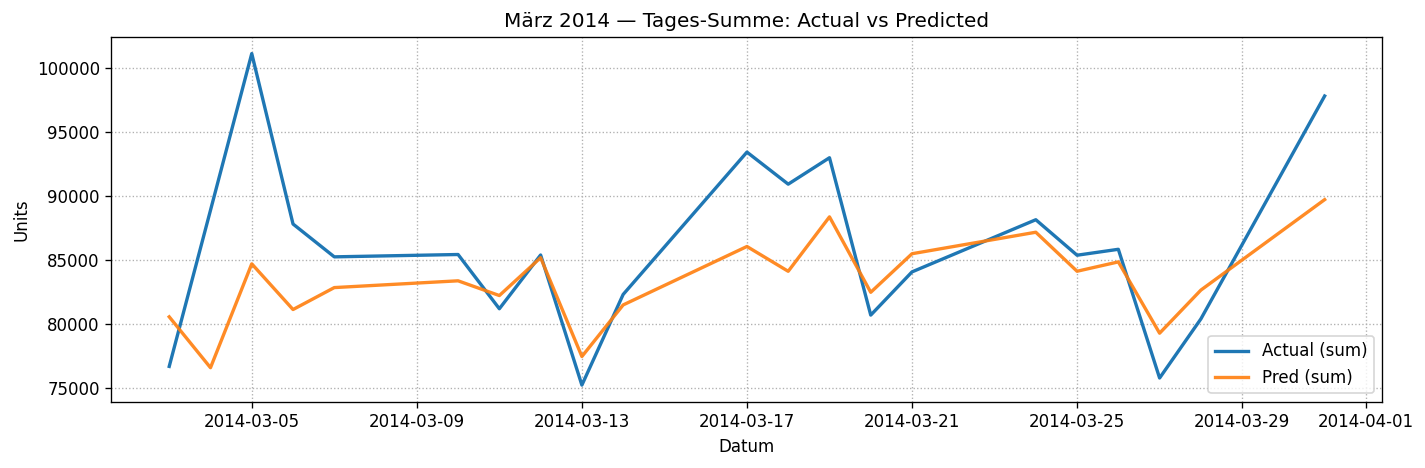

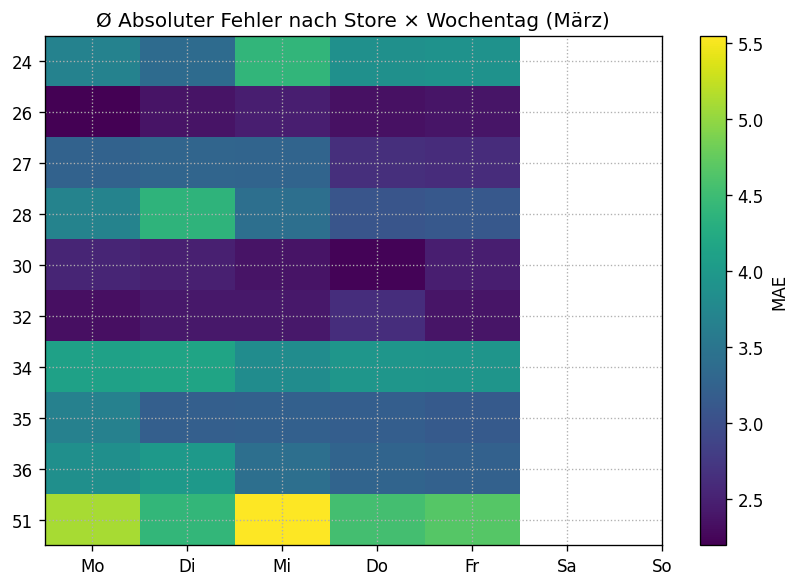

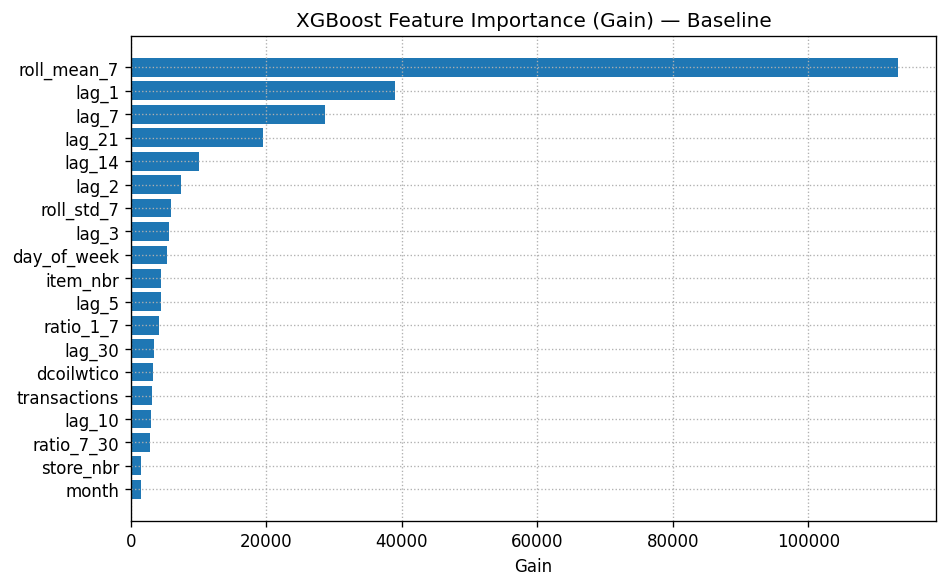

Artefakte gespeichert: ['/content/drive/MyDrive/time_series_course_guayas/artifacts_week2_3/daily_sum_baseline.png', '/content/drive/MyDrive/time_series_course_guayas/artifacts_week2_3/heatmap_store_dow_baseline.png', '/content/drive/MyDrive/time_series_course_guayas/artifacts_week2_3/feature_importance_baseline.png']


In [44]:
# 1) Tages-Summen (März) – Actual vs Pred
plot_df = test[["date"]].copy()
plot_df["y_true"] = y_true
plot_df["y_pred"] = y_pred_base
daily = plot_df.groupby("date", as_index=False).sum()

plt.figure(figsize=(12,4))
plt.plot(daily["date"], daily["y_true"], label="Actual (sum)", linewidth=2)
plt.plot(daily["date"], daily["y_pred"], label="Pred (sum)", linewidth=2, alpha=0.9)
plt.title("März 2014 — Tages-Summe: Actual vs Predicted")
plt.legend(); plt.xlabel("Datum"); plt.ylabel("Units")
fig1_path = f"{ART_DIR}/daily_sum_baseline.png"
plt.tight_layout(); plt.savefig(fig1_path); plt.show()

# 2) Fehler-Heatmap (Store × Wochentag, MAE)
err_df = test[["date","store_nbr"]].copy()
err_df["ae"]  = np.abs(y_true - y_pred_base)
err_df["dow"] = err_df["date"].dt.dayofweek
pivot = err_df.pivot_table(index="store_nbr", columns="dow", values="ae", aggfunc="mean").fillna(0)

plt.figure(figsize=(7,5))
plt.imshow(pivot.values, aspect="auto")
plt.xticks(range(7), ["Mo","Di","Mi","Do","Fr","Sa","So"])
plt.yticks(range(len(pivot.index)), pivot.index)
plt.title("Ø Absoluter Fehler nach Store × Wochentag (März)")
cbar = plt.colorbar(); cbar.set_label("MAE")
fig2_path = f"{ART_DIR}/heatmap_store_dow_baseline.png"
plt.tight_layout(); plt.savefig(fig2_path); plt.show()

# 3) Feature Importance (Gain) – nach Namen
# Mapping
fscore = booster_base.get_score(importance_type="gain")
imp_df = pd.DataFrame(
    {"Feature": list(fscore.keys()), "Gain": list(fscore.values())}
).sort_values("Gain", ascending=False)

plt.figure(figsize=(8,5))
plt.barh(imp_df["Feature"], imp_df["Gain"])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance (Gain) — Baseline")
plt.xlabel("Gain")
fig3_path = f"{ART_DIR}/feature_importance_baseline.png"
plt.tight_layout(); plt.savefig(fig3_path); plt.show()

print("Artefakte gespeichert:", [fig1_path, fig2_path, fig3_path])

## 🧱 Block 6 — MLflow: Baseline-Run loggen

In [45]:
mlflow.set_experiment("Retail Forecast Models (Guayas Q1 2014)")

with mlflow.start_run(run_name="Baseline_XGB"):
    mlflow.set_tag("model", "XGBoost")
    mlflow.log_params(params_base)
    for k,v in m_base.items():
        mlflow.log_metric(k, float(v))
    # Plots als Artefakte
    mlflow.log_artifact(fig1_path)
    mlflow.log_artifact(fig2_path)
    mlflow.log_artifact(fig3_path)
    # Booster als Modell (Sklearn-Wrapper umgehen → pkl via Booster.save_model)
    model_path = f"{ART_DIR}/xgb_baseline.json"
    booster_base.save_model(model_path)
    mlflow.log_artifact(model_path)

## 🧱 Block 7 — Tuning (schlankes Random-Search, Zeitreihen-sauber)

In [46]:
import itertools, random
random.seed(42)

search_space = {
    "eta":              [0.03, 0.05, 0.07, 0.1],
    "max_depth":        [4,5,6,7],
    "subsample":        [0.7, 0.85, 1.0],
    "colsample_bytree": [0.7, 0.85, 1.0],
    "reg_lambda":       [0.5, 1.0, 2.0],
    "min_child_weight": [1, 3, 5],
}

def sample_configs(space, n=25):
    # zufällige Kombinationen
    keys = list(space.keys())
    choices = [space[k] for k in keys]
    all_combos = list(itertools.product(*choices))
    random.shuffle(all_combos)
    for combo in all_combos[:n]:
        yield dict(zip(keys, combo))

best_rmse = float("inf")
best_cfg  = None
best_booster = None

for i, cfg in enumerate(sample_configs(search_space, n=25), 1):
    params = {
        **params_base,              # Basis bleibt
        "eta": cfg["eta"],
        "max_depth": cfg["max_depth"],
        "subsample": cfg["subsample"],
        "colsample_bytree": cfg["colsample_bytree"],
        "reg_lambda": cfg["reg_lambda"],
        "min_child_weight": cfg["min_child_weight"],
    }
    bst = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=False,
    )
    # Val-RMSE ist eval_metric
    rmse_val = float(bst.best_score)
    if rmse_val < best_rmse:
        best_rmse = rmse_val
        best_cfg  = params
        best_booster = bst

print("Bestes Val-RMSE:", round(best_rmse,4))
print("Beste Params:", {k:best_cfg[k] for k in ["eta","max_depth","subsample","colsample_bytree","reg_lambda","min_child_weight"]})

Bestes Val-RMSE: 7.8288
Beste Params: {'eta': 0.03, 'max_depth': 6, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_lambda': 2.0, 'min_child_weight': 1}


## 🧱 Block 8 — Best-Model testen (März), visualisieren & MLflow-Run #2

Best Tuned XGB: {'MAE': 3.4945, 'RMSE': 9.4968, 'Bias': -0.3322, 'MAD': 3.4945, 'rMAD': 0.4193, 'MAPE': 78.917, 'sMAPE': 49.6072}


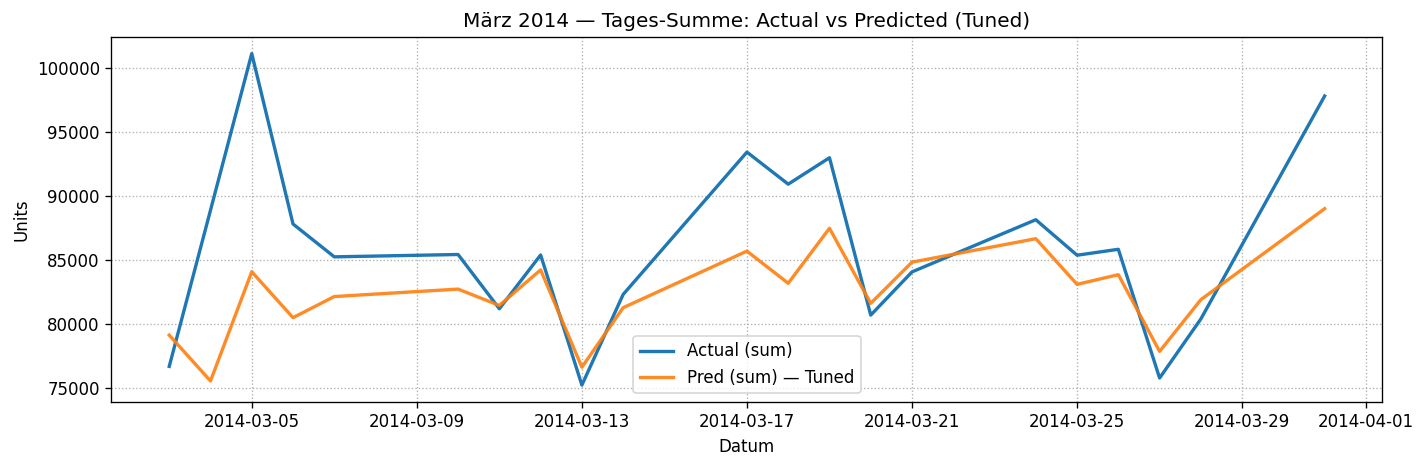

In [47]:
# Test auf März
y_pred_best = best_booster.predict(dtest, iteration_range=(0, best_booster.best_iteration+1))
m_best = metrics_all(y_true, y_pred_best)
print("Best Tuned XGB:", {k:round(v,4) for k,v in m_best.items()})

# Plot (Tages-Summen) neu mit Best
plot_df2 = test[["date"]].copy()
plot_df2["y_true"] = y_true
plot_df2["y_pred"] = y_pred_best
daily2 = plot_df2.groupby("date", as_index=False).sum()

plt.figure(figsize=(12,4))
plt.plot(daily2["date"], daily2["y_true"], label="Actual (sum)", linewidth=2)
plt.plot(daily2["date"], daily2["y_pred"], label="Pred (sum) — Tuned", linewidth=2, alpha=0.9)
plt.title("März 2014 — Tages-Summe: Actual vs Predicted (Tuned)")
plt.legend(); plt.xlabel("Datum"); plt.ylabel("Units")
fig_best_path = f"{ART_DIR}/daily_sum_tuned.png"
plt.tight_layout(); plt.savefig(fig_best_path); plt.show()

# MLflow: Run #2 (nur Gewinner-Konfig)
with mlflow.start_run(run_name="Best_XGB_Tuned"):
    mlflow.set_tag("model", "XGBoost")
    tune_params = {k: best_cfg[k] for k in ["eta","max_depth","subsample","colsample_bytree","reg_lambda","min_child_weight"]}
    mlflow.log_params(tune_params)
    for k,v in m_best.items():
        mlflow.log_metric(k, float(v))
    # Artefakt
    mlflow.log_artifact(fig_best_path)
    # Modell
    best_model_path = f"{ART_DIR}/xgb_best.json"
    best_booster.save_model(best_model_path)
    mlflow.log_artifact(best_model_path)

## 🧱 Block 9 — Artefakte für Week 4 speichern (Feature-Liste, Modelle)

In [48]:
# Feature-Liste & Meta
prep_meta = {
    "features": FEATURES,
    "target": TARGET,
    "train_window": "2014-01-01 … 2014-02-28 (Val = letzte 7 Tage Feb)",
    "test_window":  "2014-03 (März)",
    "dataset": os.path.basename(PARQUET),
}
with open(f"{ART_DIR}/preprocessing_meta.json","w") as f:
    json.dump(prep_meta, f, indent=2)

# Modelle ablegen (für Streamlit später)
save_dir_models = f"{DRIVE_ROOT}/models"
os.makedirs(save_dir_models, exist_ok=True)
Path(f"{save_dir_models}/xgb_baseline.json").write_text(Path(f"{ART_DIR}/xgb_baseline.json").read_text())
Path(f"{save_dir_models}/xgb_best.json").write_text(Path(f"{ART_DIR}/xgb_best.json").read_text())

print("Gespeichert:")
print(" -", f"{ART_DIR}/preprocessing_meta.json")
print(" -", f"{save_dir_models}/xgb_baseline.json")
print(" -", f"{save_dir_models}/xgb_best.json")

Gespeichert:
 - /content/drive/MyDrive/time_series_course_guayas/artifacts_week2_3/preprocessing_meta.json
 - /content/drive/MyDrive/models/xgb_baseline.json
 - /content/drive/MyDrive/models/xgb_best.json


## 🧱 Block 10 — Mini-LSTM zum Vergleichen

LSTM (optional, PyTorch): {'MAE': 6.2627, 'RMSE': 16.6651, 'Bias': -3.2858, 'MAD': 6.2627, 'rMAD': 0.7515, 'MAPE': 120.7734, 'sMAPE': 74.841}


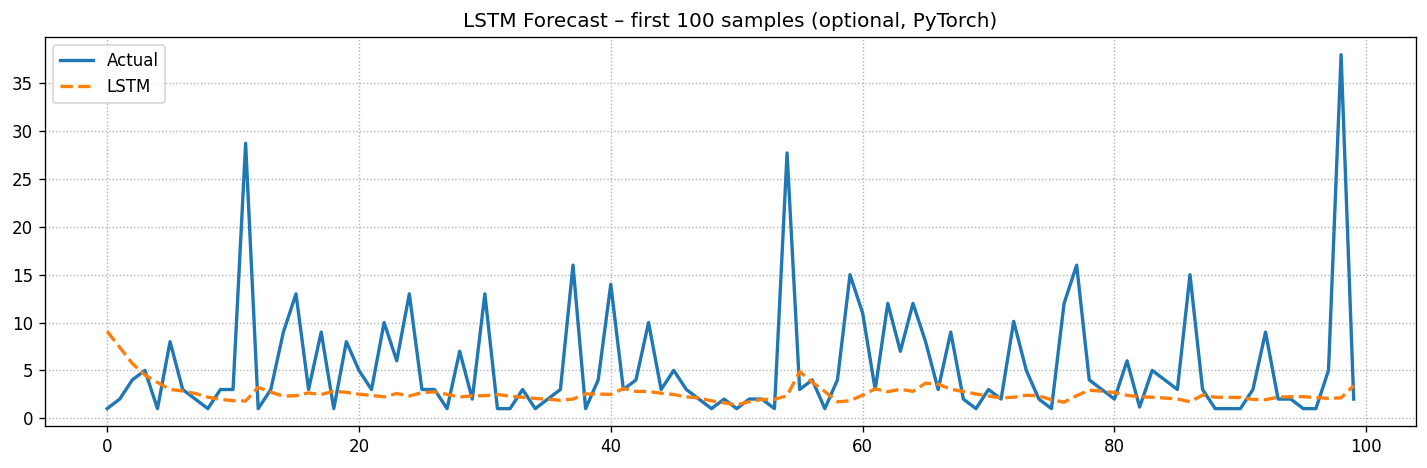

In [50]:
# 🧱 Block 10 — Mini-LSTM zum Vergleichen (robust)

# (1) PyTorch installieren (CPU-Build)
!pip -q install torch --index-url https://download.pytorch.org/whl/cpu

import os, warnings, numpy as np, matplotlib.pyplot as plt, math
warnings.filterwarnings("ignore")

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MinMaxScaler

# --- Vorbedingungen
assert 'FEATURES' in globals() and 'TARGET' in globals(), "FEATURES/TARGET nicht gefunden."
assert 'train_all' in globals() and 'test' in globals(), "train_all/test fehlen (Block 3)."

# Falls metrics_all aus Block 4 fehlt (z.B. bei Teillauf), minimal definieren
if 'metrics_all' not in globals():
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    def metrics_all(y, yhat):
        mae  = mean_absolute_error(y, yhat)
        rmse = math.sqrt(mean_squared_error(y, yhat))
        bias = float(np.mean(yhat - y))
        mad  = float(np.mean(np.abs(yhat - y)))
        rmad = float(mad / (np.mean(y) + 1e-9))
        mape = float(np.mean(np.abs((y - yhat) / (np.maximum(np.abs(y), 1e-9)))) * 100)
        smape= float(np.mean(2*np.abs(yhat - y)/(np.abs(yhat)+np.abs(y)+1e-9))*100)
        return dict(MAE=mae, RMSE=rmse, Bias=bias, MAD=mad, rMAD=rmad, MAPE=mape, sMAPE=smape)

# (2) Daten zusammenführen (Train + Test) wie im XGB-Teil
xgb_df = pd.concat([train_all, test], axis=0, ignore_index=True)
xgb_df = xgb_df.dropna(subset=[TARGET]).copy()

# --- NEU: Features robust säubern (gegen NaN/±∞/Ausreißer)
X_all_df = xgb_df[FEATURES].copy()
X_all_df = X_all_df.astype("float64", copy=False)
X_all_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Spalten-Mediane für Imputation
meds = X_all_df.median(numeric_only=True)
X_all_df = X_all_df.fillna(meds)

# Sanftes Clipping (0.1% / 99.9% Quantile)
q_low  = X_all_df.quantile(0.001, numeric_only=True)
q_high = X_all_df.quantile(0.999, numeric_only=True)
X_all_df = X_all_df.clip(lower=q_low, upper=q_high, axis=1)

# Letzte Sicherheitschecks
X_all = X_all_df.values.astype(np.float64, copy=False)
assert np.isfinite(X_all).all(), "Es sind noch NaN/Inf in X_all – bitte vorherige Blöcke prüfen."

y_all = xgb_df[TARGET].astype("float64").values.reshape(-1, 1)

# (3) Skalierung
sc_x = MinMaxScaler()
sc_y = MinMaxScaler()
X_all_s = sc_x.fit_transform(X_all).astype(np.float32)
y_all_s = sc_y.fit_transform(y_all).astype(np.float32)

# (4) Sequenzen bauen (rolling window)
def make_seq(X, y, win=30):
    Xs, ys = [], []
    for i in range(win, len(X)):
        Xs.append(X[i - win:i])
        ys.append(y[i])
    return np.asarray(Xs, dtype=np.float32), np.asarray(ys, dtype=np.float32)

WIN = 30
Xs, ys = make_seq(X_all_s, y_all_s, win=WIN)
if Xs.shape[0] < 150:
    WIN = 14
    Xs, ys = make_seq(X_all_s, y_all_s, win=WIN)
if Xs.shape[0] < 80:
    WIN = 7
    Xs, ys = make_seq(X_all_s, y_all_s, win=WIN)

assert Xs.shape[0] > 50, f"Zu wenig Sequenzen ({Xs.shape[0]}). WIN={WIN} ist Minimum – check vorherige Blöcke."

# (5) Zeitkonsistenter Split analog XGB
n_train = len(train_all.dropna(subset=FEATURES + [TARGET]))
n_test  = len(test.dropna(subset=FEATURES + [TARGET]))
n_train_seq = max(n_train - WIN, 0)
assert n_train_seq > 20, "Train-Teil für LSTM zu kurz – prüfe Splits / WIN."

Xtr, Xte = Xs[:n_train_seq], Xs[n_train_seq:]
ytr, yte = ys[:n_train_seq], ys[n_train_seq:]

# (6) Torch-Tensors + DataLoader
Xtr_t = torch.from_numpy(Xtr)  # (N, WIN, F)
ytr_t = torch.from_numpy(ytr)  # (N, 1)
Xte_t = torch.from_numpy(Xte)
yte_t = torch.from_numpy(yte)

train_ratio = 0.9
n_total = len(Xtr_t)
n_train_sub = int(n_total * train_ratio)
n_val_sub = max(n_total - n_train_sub, 1)
train_ds, val_ds = random_split(
    TensorDataset(Xtr_t, ytr_t),
    [n_train_sub, n_val_sub],
    generator=torch.Generator().manual_seed(42)
)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False)
test_loader  = DataLoader(TensorDataset(Xte_t, yte_t), batch_size=batch_size, shuffle=False)

# (7) Mini-LSTM Architektur
class MiniLSTM(nn.Module):
    def __init__(self, in_feats, hidden1=96, hidden2=32, dropout=0.2):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=in_feats, hidden_size=hidden1, batch_first=True)
        self.drop  = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(input_size=hidden1, hidden_size=hidden2, batch_first=True)
        self.fc1   = nn.Linear(hidden2, 16)
        self.act   = nn.ReLU()
        self.out   = nn.Linear(16, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.drop(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        x = self.act(self.fc1(x))
        return self.out(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MiniLSTM(in_feats=Xtr.shape[2]).to(device)

# (8) Training mit Early Stopping
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 25
patience = 3
best_val = float("inf")
wait = 0
best_state = None

def run_epoch(dl, train=True):
    if train:
        model.train()
    else:
        model.eval()
    loss_sum, n = 0.0, 0
    with torch.set_grad_enabled(train):
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            if train:
                optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            if train:
                loss.backward()
                optimizer.step()
            loss_sum += loss.item() * xb.size(0)
            n += xb.size(0)
    return loss_sum / max(n, 1)

for ep in range(1, EPOCHS + 1):
    tr_loss = run_epoch(train_loader, train=True)
    vl_loss = run_epoch(val_loader,   train=False) if len(val_ds) > 0 else tr_loss
    # Early Stopping
    if vl_loss < best_val - 1e-6:
        best_val = vl_loss
        wait = 0
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    else:
        wait += 1
        if wait >= patience:
            break

if best_state is not None:
    model.load_state_dict(best_state)

# (9) Inferenz (Test) + Rückskalierung
model.eval()
preds_s, trues_s = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pb = model(xb).cpu().numpy()
        preds_s.append(pb)
        trues_s.append(yb.numpy())

yp_s = np.vstack(preds_s)             # scaled
yt_s = np.vstack(trues_s)

yp = sc_y.inverse_transform(yp_s).ravel()
y_true_lstm = xgb_df.iloc[n_train:][TARGET].values
y_true_lstm = y_true_lstm[-len(yp):]

# (10) Metriken & Plot
m_lstm = metrics_all(y_true_lstm, yp)
print("LSTM (optional, PyTorch):", {k: round(float(v), 4) for k, v in m_lstm.items()})

plt.figure(figsize=(12, 4))
plt.plot(y_true_lstm[:100], label="Actual", linewidth=2)
plt.plot(yp[:100],          label="LSTM",   linestyle="--", linewidth=2)
plt.title("LSTM Forecast – first 100 samples (optional, PyTorch)")
plt.legend(); plt.tight_layout(); plt.grid(True, ls=":")
plt.show()

## 🧱 Block 11 — Leak-/Split-Checks & Grund-Metriken

In [51]:
# Prüfen, ob Features versehentlich Zukunft sehen & ob Splits passen
assert set(FEATURES).issubset(set(train_all.columns)), "FEATURES fehlen in train_all."
assert TARGET in train_all.columns, "TARGET fehlt."

def check_leakage(df, time_col="date", group_cols=["store_nbr","item_nbr"]):
    # einfache Heuristik: Lags dürfen nicht NaN-frei direkt am Fold-Schnitt starten
    suspects = []
    for c in FEATURES:
        if "lag" in c or "avg" in c:
            frac_na = df[c].isna().mean()
            if frac_na == 0.0:
                suspects.append(c)
    return suspects

xgb_df = pd.concat([train_all, test], axis=0, ignore_index=True)
leaks = check_leakage(xgb_df)
print("🔎 Potenzielle Leak-Features (prüfen!):", leaks or "keine gefunden")

# Baseline-Metriken deines existierenden XGB (falls 'yp_xgb_test' existiert) und LSTM (Block 10)
if 'yp_xgb_test' in globals() and 'y_true_xgb' in globals():
    print("XGB Test:", {k: round(v,4) for k,v in metrics_all(y_true_xgb, yp_xgb_test).items()})
# LSTM alias (aus Block 10 heißt das Modell 'model')
try:
    model_lstm_alias = model  # MiniLSTM aus Block 10
except NameError:
    model_lstm_alias = None

🔎 Potenzielle Leak-Features (prüfen!): ['lag_1', 'lag_7', 'lag_14', 'lag_30', 'lag_2', 'lag_3', 'lag_5', 'lag_10', 'lag_21']


## 🧱 Block 12 — Rolling-Origin Backtesting (XGBoost, Early Stopping)

Fold 1:  {'MAE': 3.222, 'RMSE': 7.3856, 'Bias': -0.0452, 'MAD': 3.222, 'rMAD': 0.4408, 'MAPE': 82.0514, 'sMAPE': 50.09}
Fold 2:  {'MAE': 3.7971, 'RMSE': 9.8886, 'Bias': -0.9458, 'MAD': 3.7971, 'rMAD': 0.4337, 'MAPE': 75.0854, 'sMAPE': 49.7375}
Fold 3:  {'MAE': 3.532, 'RMSE': 7.7327, 'Bias': 0.6047, 'MAD': 3.532, 'rMAD': 0.4264, 'MAPE': 86.7222, 'sMAPE': 50.5703}
Fold 4:  {'MAE': 3.3377, 'RMSE': 8.4841, 'Bias': -0.1335, 'MAD': 3.3377, 'rMAD': 0.408, 'MAPE': 77.8927, 'sMAPE': 49.0243}
Fold 5:  {'MAE': 3.2999, 'RMSE': 9.3401, 'Bias': 0.1846, 'MAD': 3.2999, 'rMAD': 0.41, 'MAPE': 81.966, 'sMAPE': 49.7266}
⛳ Backtest-Ø: {'MAE': np.float64(3.4377), 'RMSE': np.float64(8.5662), 'Bias': np.float64(-0.067), 'MAD': np.float64(3.4377), 'rMAD': np.float64(0.4238), 'MAPE': np.float64(80.7435), 'sMAPE': np.float64(49.8297)}


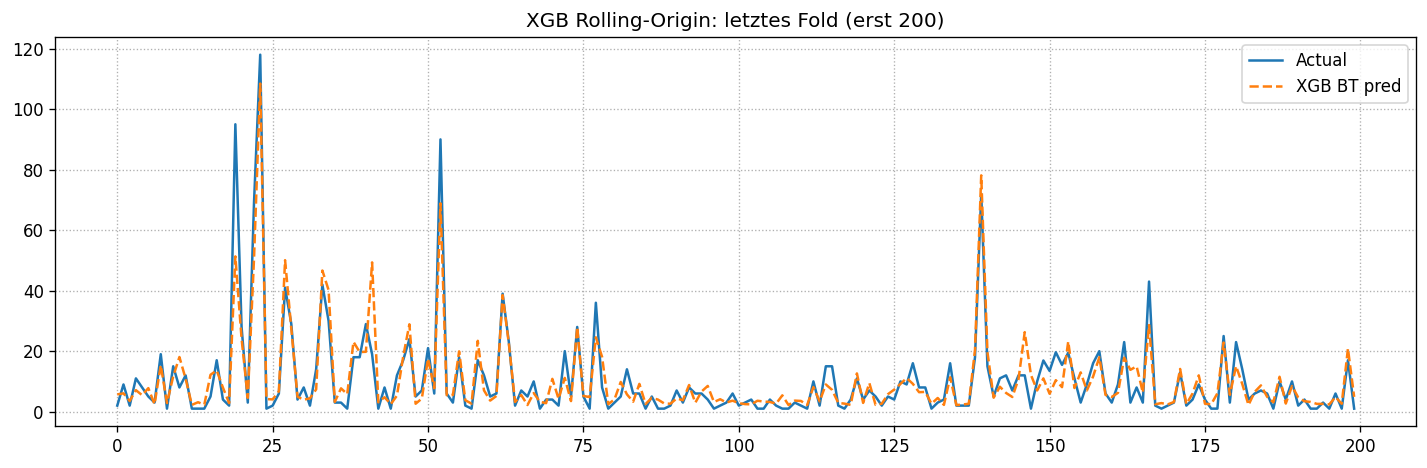

In [53]:
# 🧱 Block 12 — Rolling-Origin Backtesting (XGBoost, Early Stopping, robust)

from sklearn.model_selection import TimeSeriesSplit
import numpy as np, matplotlib.pyplot as plt

# Daten wie im XGB-Teil aufbereiten
df_bt = xgb_df.dropna(subset=FEATURES+[TARGET]).copy()

# 🔧 Cleanstep gegen ±inf / extreme Werte
df_bt = df_bt.replace([np.inf, -np.inf], np.nan)
meds = df_bt[FEATURES].median(numeric_only=True)
df_bt[FEATURES] = df_bt[FEATURES].fillna(meds)
q_low  = df_bt[FEATURES].quantile(0.001, numeric_only=True)
q_high = df_bt[FEATURES].quantile(0.999, numeric_only=True)
df_bt[FEATURES] = df_bt[FEATURES].clip(lower=q_low, upper=q_high, axis=1)

X = df_bt[FEATURES].astype(float).values
y = df_bt[TARGET].astype(float).values
assert np.isfinite(X).all(), "❌ Noch Inf/NaN in den Features – prüfe Vorverarbeitung!"

# 5 Folds, expandierend (rolling-origin)
tscv = TimeSeriesSplit(n_splits=5)
fold_metrics = []
fold_preds = np.full_like(y, fill_value=np.nan, dtype=float)

for f, (tr, te) in enumerate(tscv.split(X, y), 1):
    dtr = xgb.DMatrix(X[tr], label=y[tr])
    dte = xgb.DMatrix(X[te], label=y[te])

    params = dict(
        objective="reg:squarederror",
        eval_metric="rmse",
        eta=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        min_child_weight=3,
        tree_method="hist"
    )
    evallist = [(dtr, "train"), (dte, "valid")]
    booster = xgb.train(
        params,
        dtr,
        num_boost_round=2000,
        evals=evallist,
        early_stopping_rounds=50,
        verbose_eval=False
    )
    yp = booster.predict(dte)
    fold_preds[te] = yp
    m = metrics_all(y[te], yp)
    fold_metrics.append(m)
    print(f"Fold {f}: ", {k: round(v, 4) for k, v in m.items()})

print("⛳ Backtest-Ø:",
      {k: round(np.nanmean([m[k] for m in fold_metrics]), 4)
       for k in fold_metrics[0].keys()})

# Vis: letztes Fold
plt.figure(figsize=(12, 4))
last_te = list(tscv.split(X, y))[-1][1]
plt.plot(y[last_te][:200], label="Actual")
plt.plot(fold_preds[last_te][:200], "--", label="XGB BT pred")
plt.legend()
plt.title("XGB Rolling-Origin: letztes Fold (erst 200)")
plt.grid(True, ls=":")
plt.tight_layout()
plt.show()

## 🧱 Block 13 — Schnelles XGB-Tuning mit Optuna (robust)

In [54]:
!pip -q install optuna
import optuna, numpy as np

dall = xgb.DMatrix(X, label=y)

def objective(trial):
    params = {
        "objective":"reg:squarederror",
        "eval_metric":"rmse",
        "eta": trial.suggest_float("eta", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
        "tree_method":"hist"
    }
    # val = letztes 10% als EarlyStopping-Val
    n = len(y); cut = int(n*0.9)
    dtr, dval = xgb.DMatrix(X[:cut], label=y[:cut]), xgb.DMatrix(X[cut:], label=y[cut:])
    booster = xgb.train(params, dtr, 2000, [(dtr,"train"),(dval,"valid")], early_stopping_rounds=50, verbose_eval=False)
    yp = booster.predict(dval)
    return float(np.sqrt(((yp - y[cut:])**2).mean()))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25, show_progress_bar=False)
best_params = study.best_params
print("🏆 Optuna-Best:", best_params)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 6.7 MB/s eta 0:00:00


[I 2025-10-15 11:14:56,669] A new study created in memory with name: no-name-a0c53244-4e2b-4652-859d-a83548c49cb7
[I 2025-10-15 11:15:03,840] Trial 0 finished with value: 10.432210748642913 and parameters: {'eta': 0.05640574089890392, 'max_depth': 5, 'subsample': 0.773786417613067, 'colsample_bytree': 0.8906648639247237, 'min_child_weight': 4.10801984988532}. Best is trial 0 with value: 10.432210748642913.
[I 2025-10-15 11:15:08,062] Trial 1 finished with value: 10.461876805358512 and parameters: {'eta': 0.08947936931269586, 'max_depth': 8, 'subsample': 0.8234647587351674, 'colsample_bytree': 0.8307690017869959, 'min_child_weight': 9.01018187264781}. Best is trial 0 with value: 10.432210748642913.
[I 2025-10-15 11:15:23,140] Trial 2 finished with value: 10.394677918237907 and parameters: {'eta': 0.03470995074573496, 'max_depth': 10, 'subsample': 0.7645715712252796, 'colsample_bytree': 0.6317497393596393, 'min_child_weight': 5.415311976580913}. Best is trial 2 with value: 10.39467791823

🏆 Optuna-Best: {'eta': 0.021698246205547334, 'max_depth': 8, 'subsample': 0.9939081172318497, 'colsample_bytree': 0.7218950588927205, 'min_child_weight': 1.2191572030537958}


## 🧱 Block 14 — SHAP für XGB (globale + lokale Erklärungen)

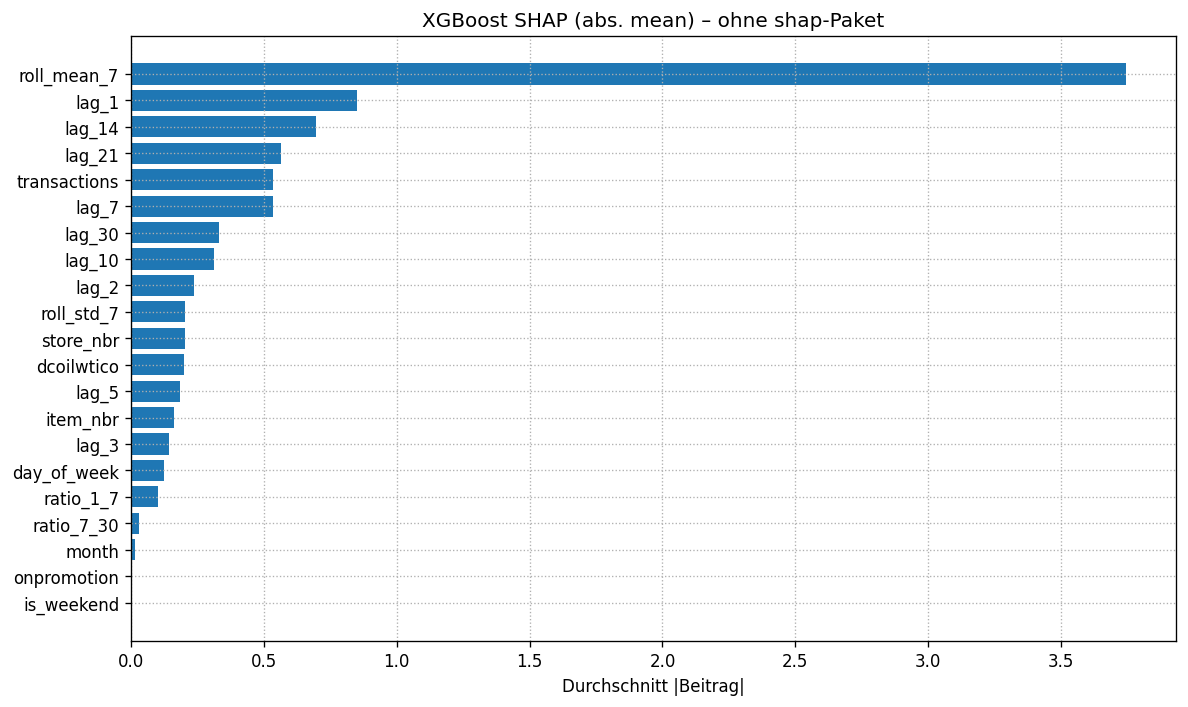

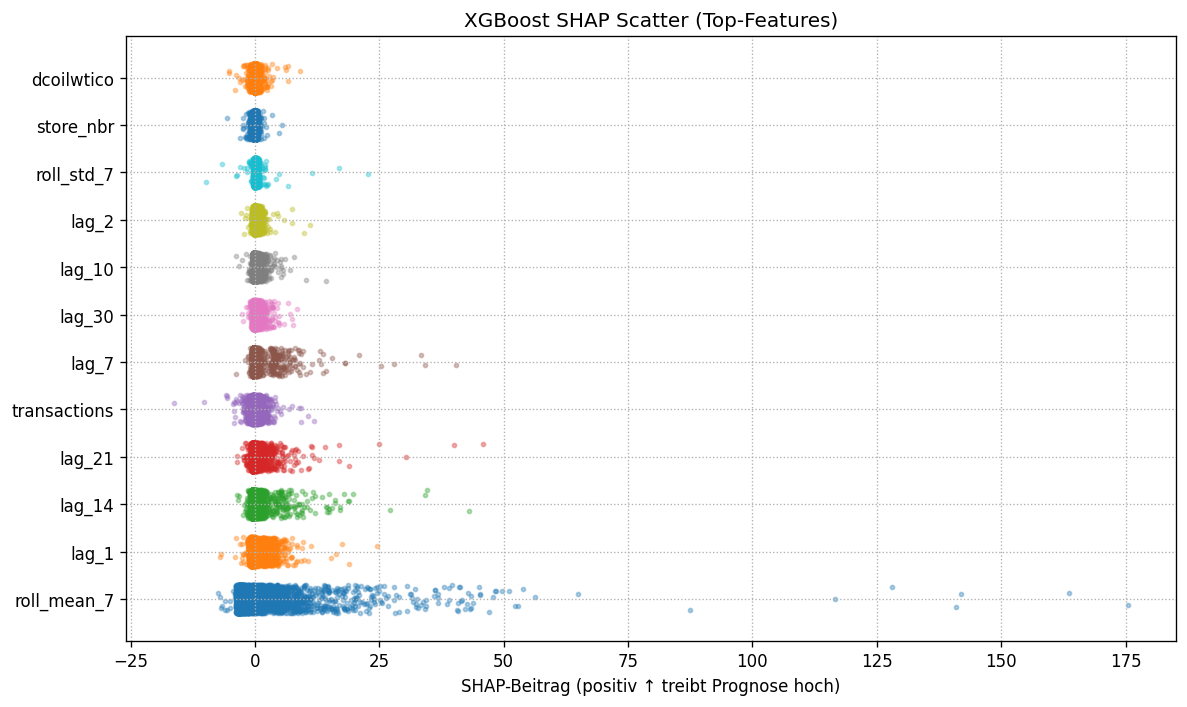

🔎 Lokale Erklärung für Sample-Index 326499
  roll_mean_7                SHAP=-0.6532
  transactions               SHAP=-0.6511
  lag_1                      SHAP=-0.6496
  lag_7                      SHAP=-0.3586
  lag_21                     SHAP=-0.3363
  roll_std_7                 SHAP= 0.3216
  lag_30                     SHAP= 0.2459
  lag_10                     SHAP= 0.1865
  ratio_1_7                  SHAP= 0.1025
  lag_2                      SHAP= 0.0948
  (Bias)                      8.2341


In [55]:
# 1) finales XGB
params_final = dict(
    objective="reg:squarederror",
    eval_metric="rmse",
    tree_method="hist",
)
if 'best_params' in globals():
    params_final.update(best_params)

dtrain = xgb.DMatrix(X, label=y)
num_round = 400
if 'study' in globals():

    try:
        num_round = max(50, int(study.best_trial.user_attrs.get("best_iteration", 400)))
    except Exception:
        pass

booster_final = xgb.train(params_final, dtrain, num_boost_round=num_round)

# 2) SHAP-Contributions direkt aus XGBoost holen
#    Achtung: letzte Spalte ist der Bias-Term -> rauswerfen
import numpy as np
import matplotlib.pyplot as plt

idx = np.random.choice(len(X), size=min(5000, len(X)), replace=False)
dsub = xgb.DMatrix(X[idx])
contribs = booster_final.predict(dsub, pred_contribs=True)   # shape: [n, F+1]
shap_vals = contribs[:, :-1]                                 # drop bias column
feature_names = np.array(FEATURES)

# 3) Globale Wichtigkeit: mittlere |SHAP|-Beträge
mean_abs = np.mean(np.abs(shap_vals), axis=0)
order = np.argsort(mean_abs)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(feature_names[order], mean_abs[order])
plt.gca().invert_yaxis()
plt.title("XGBoost SHAP (abs. mean) – ohne shap-Paket")
plt.xlabel("Durchschnitt |Beitrag|")
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()

# 4)einfache "Beeswarm"-ähnliche Streuung für Top-Features
top_k = min(12, len(feature_names))
top_feats = order[:top_k]

plt.figure(figsize=(10, 6))
for rank, fidx in enumerate(top_feats):
    y_jitter = rank + (np.random.rand(len(idx)) - 0.5) * 0.6
    plt.scatter(shap_vals[:, fidx], y_jitter, s=6, alpha=0.35)
plt.yticks(range(top_k), feature_names[top_feats])
plt.title("XGBoost SHAP Scatter (Top-Features)")
plt.xlabel("SHAP-Beitrag (positiv ↑ treibt Prognose hoch)")
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()

# 5)lokale Erklärung für eine einzelne Zeile
i_local = int(idx[0])  # nimm eine Beispieldatenzeile
x_local = X[i_local:i_local+1]
d_local = xgb.DMatrix(x_local)
local_contrib = booster_final.predict(d_local, pred_contribs=True)[0]
local_shap = local_contrib[:-1]
bias = local_contrib[-1]

top_local = np.argsort(np.abs(local_shap))[::-1][:10]
print("🔎 Lokale Erklärung für Sample-Index", i_local)
for j in top_local:
    print(f"  {feature_names[j]:<25}  SHAP={local_shap[j]: .4f}")
print(f"  {'(Bias)':<25}  {bias: .4f}")

## 🧱 Block 15 — Residual-Diagnostik (by Store/Item/DOW) + Ausreißer

🔧 Fehler nach store_nbr (Top 10 nach medianer |Abweichung|):


,mean,median,mean_abs,med_abs
store_nbr,,,,
51,0.113573,-0.576335,4.642888,2.309301
34,-0.365207,-0.809403,3.976812,2.055872
24,0.228538,-0.464457,3.715510,2.055321
36,0.265209,-0.522479,3.539843,1.733730
28,0.174943,-0.604233,3.435453,1.721972
35,-0.057561,-0.741008,3.411742,1.649506
27,0.036001,-0.522246,2.946729,1.623912
30,0.103540,-0.562956,2.432508,1.362750
32,0.184272,-0.454562,2.334014,1.293128


🔧 Fehler nach item_nbr (Top 10 nach medianer |Abweichung|):


,mean,median,mean_abs,med_abs
item_nbr,,,,
1503844,28.781598,6.957744,72.407654,44.313394
1167614,4.791274,-2.995674,31.959271,24.037273
257847,4.272797,-5.421956,37.113282,22.506487
1036317,20.279390,4.172336,30.414110,21.721563
1503847,-7.990403,-1.727799,34.966501,20.565321
1695837,15.336095,20.541199,15.336095,20.541199
1346636,-20.266342,-20.266342,20.266342,20.266342
812769,-5.622522,-6.259626,25.949362,18.334118
1473479,4.670204,-1.468952,24.135844,17.503311


🔧 Fehler nach day_of_week (Top 10 nach medianer |Abweichung|):


,mean,median,mean_abs,med_abs
day_of_week,,,,
1,0.110847,-0.539373,3.466348,1.760528
0,0.143697,-0.505315,3.567051,1.757844
2,0.226593,-0.568323,3.496930,1.746009
4,0.046639,-0.612925,3.395317,1.741897
3,-0.200976,-0.709509,3.248236,1.689545


⚠️ starke Ausreißer: 18679 Zeilen (Schwelle = 9.6086)


,date,store_nbr,item_nbr,unit_sales,pred_bt,resid
57413,2014-02-17,32,364606,34.000,18.023239,15.976761
57447,2014-02-17,32,467808,14.000,4.036162,9.963838
57452,2014-02-17,32,510054,16.000,5.092972,10.907028
57509,2014-02-17,32,749421,35.000,18.351480,16.648520
57536,2014-02-17,32,830624,29.000,3.224308,25.775692
57575,2014-02-17,32,903283,22.157,11.849664,10.307336
57652,2014-02-17,32,1114566,29.000,8.992140,20.007860
57690,2014-02-17,32,1167545,19.000,3.787457,15.212543
57701,2014-02-17,32,1230426,13.000,2.301368,10.698632
57708,2014-02-17,32,1239820,18.000,5.293055,12.706945


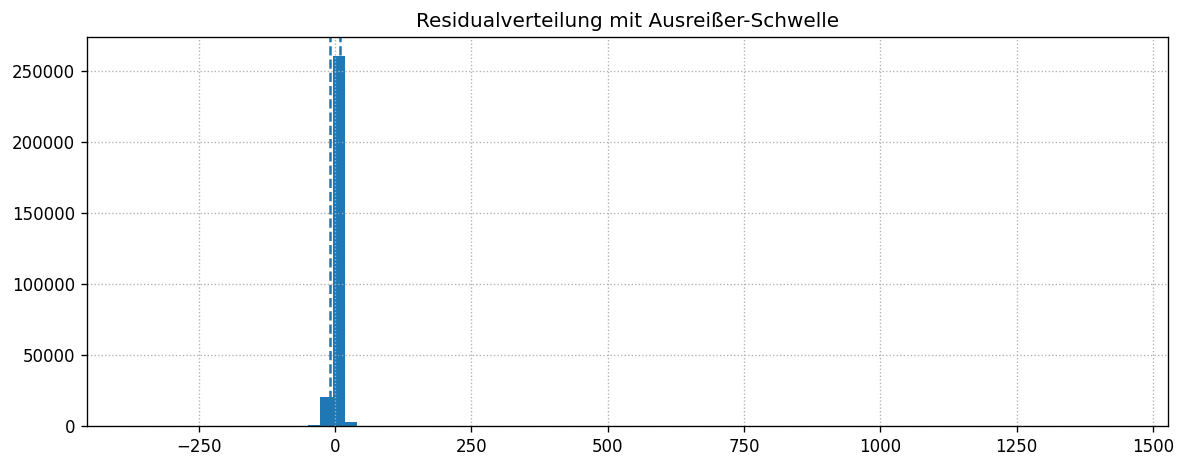

In [56]:
# 0) Residuals vorbereiten (Backtest-Vorhersagen vs. Ist)
bt_df = df_bt.copy()
bt_df["pred_bt"] = np.asarray(fold_preds)
bt_df["resid"] = bt_df[TARGET] - bt_df["pred_bt"]

# kleine Schutzklausel, falls Längen nicht exakt matchen
if len(bt_df) != len(fold_preds):
    print("⚠️ Warnung: Länge bt_df != fold_preds – prüfe deine Backtest-Zusammenführung.")

# 1) eigene Aggregationsfunktionen
def mean_abs(x):
    return np.mean(np.abs(x))

def median_abs(x):
    return np.median(np.abs(x))

def agg_and_show(key):
    g = (
        bt_df.dropna(subset=["resid"])
             .groupby(key)["resid"]
             .agg(
                 mean="mean",
                 median="median",
                 mean_abs=mean_abs,
                 med_abs=median_abs
             )
             .sort_values("med_abs", ascending=False)
    )
    print(f"🔧 Fehler nach {key} (Top 10 nach medianer |Abweichung|):")
    try:
        display(g.head(10))
    except NameError:
        print(g.head(10))

# 2) Gruppendiagnostik
keys = ["store_nbr","item_nbr"]
if "day_of_week" in bt_df.columns:
    keys.append("day_of_week")

for k in keys:
    agg_and_show(k)

# 3) Robuste Ausreißer-Erkennung via (unskaliertem) MAD um die Median-Residuen
resid_clean = bt_df["resid"].dropna().values
med = np.median(resid_clean)
mad = np.median(np.abs(resid_clean - med))  # "median absolute deviation"

# Schwelle: 6 * MAD (robust). Falls MAD==0, fallback auf 6 * mean_abs
thr = 6 * mad if mad > 0 else 6 * np.mean(np.abs(resid_clean))

out_mask = bt_df["resid"].abs() > thr
out_idx = bt_df.index[out_mask]
print(f"⚠️ starke Ausreißer: {out_mask.sum()} Zeilen (Schwelle = {thr:.4f})")

# Ein paar Beispiele zeigen
try:
    display(bt_df.loc[out_idx, ["date","store_nbr","item_nbr",TARGET,"pred_bt","resid"]].head(10))
except NameError:
    print(bt_df.loc[out_idx, ["date","store_nbr","item_nbr",TARGET,"pred_bt","resid"]].head(10))

# Histogramm der Residuen
plt.figure(figsize=(10,4))
plt.hist(bt_df["resid"].dropna(), bins=80)
plt.axvline(med + thr, ls="--")
plt.axvline(med - thr, ls="--")
plt.title("Residualverteilung mit Ausreißer-Schwelle")
plt.tight_layout()
plt.show()

## 🧱 Block 16 — Conformal Prediction Intervals (modellagnostisch)

In [57]:
# Kalibriere auf letztem 10% von TRAIN (nicht TEST!), wende auf TEST an
n_all = len(df_bt)
cut = int(n_all*0.9)
resid_cal = (bt_df.iloc[:cut][TARGET] - bt_df.iloc[:cut]["pred_bt"]).abs().dropna().values
q = np.quantile(resid_cal, 0.9)  # 90%-Intervall; passe an (0.8/0.95 …)
print(f"📏 Conformal Halbbreite (90%): {q:.3f}")

bt_df["pi_lo"] = bt_df["pred_bt"] - q
bt_df["pi_hi"] = bt_df["pred_bt"] + q

# Coverage auf Holdout
mask_hold = ~bt_df["pred_bt"].iloc[cut:].isna()
y_hold = bt_df[TARGET].iloc[cut:][mask_hold].values
lo = bt_df["pi_lo"].iloc[cut:][mask_hold].values
hi = bt_df["pi_hi"].iloc[cut:][mask_hold].values
coverage = np.mean((y_hold >= lo) & (y_hold <= hi))
print(f"✅ Empirische Coverage ~{coverage*100:.1f}% (Ziel ~90%)")

📏 Conformal Halbbreite (90%): 7.286
✅ Empirische Coverage ~90.7% (Ziel ~90%)


## 🧱 Block 17 — Simple Ensemble (XGB ⊕ LSTM, Gewicht auto-getuned)

🤝 Bestes Ensemblé-Gewicht: alpha(LSTM)=0.000  → RMSE=10.4685


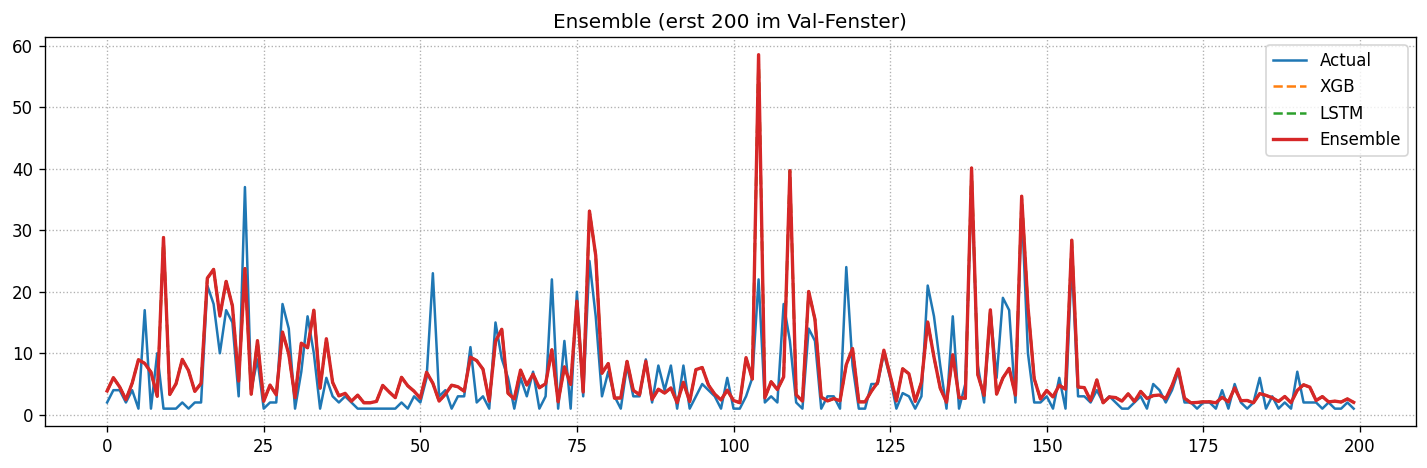

In [58]:
if 'yp' in globals():
    l = len(yp)
    yp_lstm_full = np.full(len(df_bt), np.nan, dtype=float)
    yp_lstm_full[-l:] = yp
else:
    raise RuntimeError("Keine LSTM-Preds (Variable 'yp') gefunden – bitte Block 10 ausführen.")

# Valid-Fenster = letztes 10%
val_slice = slice(cut, len(df_bt))
xgb_val = bt_df["pred_bt"].values[val_slice]
lstm_val = yp_lstm_full[val_slice]
y_val   = df_bt[TARGET].values[val_slice]
mask = ~np.isnan(xgb_val) & ~np.isnan(lstm_val)

alphas = np.linspace(0,1,41)  # 0.0,0.025,…,1.0
best_alpha, best_rmse = None, 1e9
for a in alphas:
    ens = a*lstm_val[mask] + (1-a)*xgb_val[mask]
    rmse = np.sqrt(((ens - y_val[mask])**2).mean())
    if rmse < best_rmse:
        best_rmse, best_alpha = rmse, a

print(f"🤝 Bestes Ensemblé-Gewicht: alpha(LSTM)={best_alpha:.3f}  → RMSE={best_rmse:.4f}")

# Finale Ensemblé-Reihe (wo beides vorhanden ist)
ensemble_full = np.where(np.isnan(yp_lstm_full), bt_df["pred_bt"].values, best_alpha*yp_lstm_full + (1-best_alpha)*bt_df["pred_bt"].values)

plt.figure(figsize=(12,4))
plt.plot(y_val[:200], label="Actual")
plt.plot(xgb_val[:200], "--", label="XGB")
plt.plot(lstm_val[:200], "--", label="LSTM")
plt.plot((best_alpha*lstm_val + (1-best_alpha)*xgb_val)[:200], label="Ensemble", linewidth=2)
plt.title("Ensemble (erst 200 im Val-Fenster)"); plt.legend(); plt.grid(True, ls=":"); plt.tight_layout(); plt.show()

## 🧱 Block 18 — Artefakte speichern (für Week-4 Streamlit)

In [59]:
import os, json, joblib, numpy as np, torch

ART_DIR = ART_DIR if 'ART_DIR' in globals() else "./artifacts_week2_3"
os.makedirs(ART_DIR, exist_ok=True)

# 1) XGB: Booster + Featureliste
xgb_model_path = os.path.join(ART_DIR, "xgb_booster.json")
booster_final.save_model(xgb_model_path)

with open(os.path.join(ART_DIR, "features.json"), "w") as f:
    json.dump({"FEATURES": FEATURES, "TARGET": TARGET}, f, indent=2)

# 2) LSTM: TorchScript + Scaler für y/x
try:
    model_lstm_alias.eval()
    example = torch.from_numpy(np.zeros((1, 30 if 'WIN' not in globals() else WIN, len(FEATURES)), dtype=np.float32))
    traced = torch.jit.trace(model_lstm_alias, example)
    torchscript_path = os.path.join(ART_DIR, "lstm_torchscript.pt")
    traced.save(torchscript_path)
    print("💾 LSTM TorchScript:", torchscript_path)
except Exception as e:
    print("⚠️ Konnte LSTM nicht speichern (TorchScript). Grund:", e)

# Scaler (aus Block 10)
try:
    joblib.dump(sc_x, os.path.join(ART_DIR, "scaler_X.pkl"))
    joblib.dump(sc_y, os.path.join(ART_DIR, "scaler_y.pkl"))
    print("💾 Scaler gespeichert.")
except:
    pass

# 3) Ensemble-Config
with open(os.path.join(ART_DIR, "ensemble.json"), "w") as f:
    json.dump({"alpha_lstm": float(best_alpha)}, f, indent=2)

# 4) Helper für Streamlit (einfacher Predictor)
predictor_py = f"""
import json, joblib, numpy as np, xgboost as xgb, torch
from typing import Dict

def load_all(art_dir: str) -> Dict:
    booster = xgb.Booster(); booster.load_model(f"{{art_dir}}/xgb_booster.json")
    with open(f"{{art_dir}}/features.json") as f: meta = json.load(f)
    try:
        lstm = torch.jit.load(f"{{art_dir}}/lstm_torchscript.pt"); lstm.eval()
    except:
        lstm = None
    try:
        sc_x = joblib.load(f"{{art_dir}}/scaler_X.pkl")
        sc_y = joblib.load(f"{{art_dir}}/scaler_y.pkl")
    except:
        sc_x = sc_y = None
    try:
        with open(f"{{art_dir}}/ensemble.json") as f: ens = json.load(f)
        alpha = float(ens.get("alpha_lstm", 0.5))
    except:
        alpha = 0.5
    return dict(booster=booster, meta=meta, lstm=lstm, sc_x=sc_x, sc_y=sc_y, alpha=alpha)

def predict_xgb(booster, X_df):
    d = xgb.DMatrix(X_df.values)
    return booster.predict(d)

def predict_lstm(lstm, sc_x, sc_y, X_df, win=30):
    if lstm is None or sc_x is None or sc_y is None:
        return None
    Xs = sc_x.transform(X_df.values).astype(np.float32)
    if len(Xs) < win: return None
    seq = np.stack([Xs[-win:]], axis=0)  # 1×WIN×F
    with torch.no_grad():
        yp_s = lstm(torch.from_numpy(seq))
    return sc_y.inverse_transform(yp_s.numpy()).ravel()

def predict_ensemble(models, X_df):
    xgb_pred = predict_xgb(models['booster'], X_df)
    lstm_pred = predict_lstm(models['lstm'], models['sc_x'], models['sc_y'], X_df, win=30)
    if lstm_pred is None:
        return xgb_pred
    # letzte XGB/Vergleichslänge
    y_l = min(len(xgb_pred), len(lstm_pred))
    ens = models['alpha']*lstm_pred[-y_l:] + (1-models['alpha'])*xgb_pred[-y_l:]
    return ens
"""
with open(os.path.join(ART_DIR, "predict.py"), "w") as f:
    f.write(predictor_py)

print("✅ Artefakte für Streamlit exportiert nach:", ART_DIR)

💾 LSTM TorchScript: /content/drive/MyDrive/time_series_course_guayas/artifacts_week2_3/lstm_torchscript.pt
💾 Scaler gespeichert.
✅ Artefakte für Streamlit exportiert nach: /content/drive/MyDrive/time_series_course_guayas/artifacts_week2_3


## 🧱 Block 19 — MLflow-Logging als Fallback-Wrapper

In [60]:
USE_MLFLOW = True
try:
    import mlflow, mlflow.sklearn
except Exception as e:
    print("MLflow nicht verfügbar:", e); USE_MLFLOW = False

if USE_MLFLOW:
    mlflow.set_experiment("Retail Forecast (clean)")
    with mlflow.start_run(run_name="xgb_final_backtest"):
        mlflow.set_tag("phase","week2_3")
        if 'best_params' in globals(): mlflow.log_params(best_params)
        avg_metrics = {k: float(np.nanmean([m[k] for m in fold_metrics])) for k in fold_metrics[0].keys()}
        mlflow.log_metrics({f"avg_{k}": v for k,v in avg_metrics.items()})
        mlflow.log_artifact(os.path.join(ART_DIR, "xgb_booster.json"))
        mlflow.log_artifact(os.path.join(ART_DIR, "features.json"))
        if os.path.exists(os.path.join(ART_DIR,"ensemble.json")):
            mlflow.log_artifact(os.path.join(ART_DIR,"ensemble.json"))
    print("📝 MLflow: Logged.")

📝 MLflow: Logged.


## 🧱 Block 20 — Inferenz-Bundle & einheitliche predict_batch()

In [61]:
from pathlib import Path
import json, os
import numpy as np
import pandas as pd
import xgboost as xgb
import pickle
from datetime import datetime

ART_DIR = ART_DIR if 'ART_DIR' in globals() else "./artifacts_week2_3"
Path(ART_DIR).mkdir(parents=True, exist_ok=True)

# 1) Booster & Featureliste einsammeln (aus früheren Blöcken)
#    Fallback: nimm booster_final, sonst lade aus Datei
booster_path = os.path.join(ART_DIR, "xgb_booster.json")
features_path = os.path.join(ART_DIR, "features.json")

if 'booster_final' in globals():
    booster_final.save_model(booster_path)

if 'FEATURES' in globals():
    with open(features_path, "w") as f:
        json.dump({"features": FEATURES, "target": TARGET}, f, indent=2)

# 2) kleines Inferenz-Metapaket
bundle = {
    "booster_path": booster_path,
    "features_path": features_path,
    "created_at": datetime.utcnow().isoformat() + "Z",
    "model_type": "xgboost_booster",
    "version": "1.0.0"
}
with open(os.path.join(ART_DIR, "inference_bundle.json"), "w") as f:
    json.dump(bundle, f, indent=2)

print("📦 Inferenz-Bundle geschrieben ->", ART_DIR)

# 3) Einfache Vorhersagefunktion für Streamlit/FastAPI
def load_bundle(art_dir=ART_DIR):
    with open(os.path.join(art_dir, "features.json"), "r") as f:
        cfg = json.load(f)
    feats = cfg["features"]
    booster = xgb.Booster()
    booster.load_model(os.path.join(art_dir, "xgb_booster.json"))
    return booster, feats, cfg.get("target")

def predict_batch(df_in: pd.DataFrame, art_dir=ART_DIR):
    """df_in muss die Spalten aus FEATURES bereits enthalten (FE-Pipeline vorher!)."""
    booster, feats, _ = load_bundle(art_dir)
    X = df_in[feats].astype(float)
    dm = xgb.DMatrix(X)
    yhat = booster.predict(dm)
    return pd.Series(yhat, index=df_in.index, name="pred_xgb")

# Smoke-Test
try:
    _sm = predict_batch(df.iloc[:5].copy())
    print("✅ predict_batch() Smoke-Test ok:", _sm.head().to_list())
except Exception as e:
    print("⚠️ predict_batch() Test fehlgeschlagen:", e)

📦 Inferenz-Bundle geschrieben -> /content/drive/MyDrive/time_series_course_guayas/artifacts_week2_3
✅ predict_batch() Smoke-Test ok: [285.8359375, 285.8359375, 285.8359375, 285.8359375, 285.8359375]


## 🧱 Block 21 — Conformal Prediction (robuste Prognoseintervalle)

In [62]:
# Voraussetzung: bt_df mit Spalten [TARGET, 'pred_bt', 'resid'] aus Block 15/12
assert 'bt_df' in globals() and 'resid' in bt_df.columns, "Backtest-Residuen fehlen (siehe Block 12/15)."

def conformal_interval_from_residuals(residuals: pd.Series, alpha=0.1):
    """Gibt die additiven Quantil-Schutzhüllen zurück (z.B. 90%-Intervall bei alpha=0.1)."""
    res = residuals.dropna().values
    q_low  = np.quantile(res, alpha/2)
    q_high = np.quantile(res, 1 - alpha/2)
    return float(q_low), float(q_high)

# Intervall aufbauen (90% und 95%)
qL90, qH90 = conformal_interval_from_residuals(bt_df["resid"], alpha=0.10)
qL95, qH95 = conformal_interval_from_residuals(bt_df["resid"], alpha=0.05)
print(f"📏 Conformal Hüllen: 90% [{qL90:+.3f}, {qH90:+.3f}] | 95% [{qL95:+.3f}, {qH95:+.3f}]")

def apply_conformal(y_pred: pd.Series, qL: float, qH: float):
    lo = y_pred + qL
    hi = y_pred + qH
    return lo.rename("pred_lo"), hi.rename("pred_hi")

# Beispiel: aktuelle Test-Vorhersage plus Intervall
try:
    y_pred_now = predict_batch(df.copy())
    lo90, hi90 = apply_conformal(y_pred_now, qL90, qH90)
    _check = pd.concat([y_pred_now.head(3), lo90.head(3), hi90.head(3)], axis=1)
    print("✅ Intervall-Sanity:\n", _check)
except Exception as e:
    print("⚠️ Intervall-Anwendung fehlgeschlagen:", e)

# Export für Streamlit
with open(os.path.join(ART_DIR, "conformal_intervals.json"), "w") as f:
    json.dump({"qL90": qL90, "qH90": qH90, "qL95": qL95, "qH95": qH95}, f, indent=2)
print("💾 conformal_intervals.json gespeichert.")

📏 Conformal Hüllen: 90% [-6.447, +8.114] | 95% [-9.835, +12.761]
⚠️ Intervall-Anwendung fehlgeschlagen: [11:27:36] /workspace/src/data/data.cc:1120: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x22dbbc) [0x79b3b842dbbc]
  [bt] (1) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x4d621b) [0x79b3b86d621b]
  [bt] (2) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x54bb8a) [0x79b3b874bb8a]
  [bt] (3) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x4cc0fe) [0x79b3b86cc0fe]
  [bt] (4) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(XGDMatrixCreateFromColumnar+0x105) [0x79b3b83609a5]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x79b40186be2e]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x79b401868493]
  [bt] (7) /usr/lib/python3.12/lib-dynload

## 🧱 Block 22 — Mini-Ensemble-Calibrator (Stacking light)

In [63]:
from sklearn.linear_model import Ridge
import numpy as np
import pandas as pd

assert 'bt_df' in globals(), "bt_df fehlt (kommt aus Backtest-Blöcken)."
assert TARGET in bt_df.columns, f"{TARGET} fehlt in bt_df."

# Welche Stacking-Quellen sind vorhanden?
stack_cols = []
if "pred_bt" in bt_df.columns:       # XGB-Backtest-Pred
    stack_cols.append("pred_bt")
if "pred_lstm_bt" in bt_df.columns:  # optional: LSTM-Backtest-Pred
    stack_cols.append("pred_lstm_bt")

if len(stack_cols) == 0:
    apply_calibrator = None
    print("ℹ️ Kein Stacking möglich (keine Stacking-Quellen in bt_df).")
else:
    # y & X aufbauen
    y_bt_full = bt_df[TARGET].to_numpy(dtype=float)
    X_full = np.column_stack([bt_df[c].to_numpy(dtype=float) for c in stack_cols])

    # gültige Zeilen (kein NaN/inf in X oder y)
    mask = np.isfinite(y_bt_full)
    mask &= np.all(np.isfinite(X_full), axis=1)

    n_all = len(y_bt_full)
    n_keep = int(mask.sum())
    n_drop = n_all - n_keep
    if n_keep < 20:
        apply_calibrator = None
        print(f"⚠️ Zu wenig saubere Daten für Calibrator (keep={n_keep}, drop={n_drop}). Überspringe Stacking.")
    else:
        y_bt = y_bt_full[mask]
        X_stack = X_full[mask]

        # Mediane für spätere Imputation merken
        col_medians = np.nanmedian(X_stack, axis=0)

        # Ridge-Fit
        cal = Ridge(alpha=1.0, fit_intercept=True)
        cal.fit(X_stack, y_bt)

        # Logging
        print(f"🧪 Calibrator fit: genutzt={n_keep}, entfernt={n_drop}")
        weights = dict(zip(stack_cols, cal.coef_.tolist()))
        print("   Intercept:", float(cal.intercept_))
        print("   Gewichte:", {k: round(v, 5) for k, v in weights.items()})

        # Anwendungsfunktion
        def apply_calibrator(df_feats: pd.DataFrame) -> pd.Series:
            """
            Erwartet:
              - XGB-Pred über predict_batch(df_feats) (aus Block 20)
              - optional df_feats['pred_lstm'] falls du LSTM schon extern berechnet hast
            Gibt kalibrierte Vorhersage 'pred_cal' zurück.
            """
            preds_list = []
            # XGB immer
            if 'predict_batch' not in globals():
                raise RuntimeError("predict_batch() nicht gefunden (siehe Block 20).")
            yx = predict_batch(df_feats).to_numpy(dtype=float)
            preds_list.append(yx)

            # ggf. LSTM (falls als Spalte vorhanden)
            if "pred_lstm" in df_feats.columns and "pred_lstm_bt" in stack_cols:
                preds_list.append(df_feats["pred_lstm"].to_numpy(dtype=float))
            elif "pred_lstm_bt" in stack_cols:
                # wenn im Calibrator LSTM erwartet wird, aber hier fehlt: mit NaN auffüllen
                preds_list.append(np.full_like(yx, np.nan, dtype=float))

            Xnew = np.column_stack(preds_list)

            # NaNs impute mit Trainingsmedianen je Spalte
            # (Anzahl Spalten von Xnew kann <len(stack_cols) sein, daher mappen)
            # Reihenfolge der Spalten in Xnew entspricht:
            #   ['pred_bt'] (+ optional 'pred_lstm') – passend zu stack_cols
            if Xnew.shape[1] != len(stack_cols):
                # Mappen: baue die Matrix exakt in stack_cols-Reihenfolge
                mats = []
                pos = 0
                for col in stack_cols:
                    if col == "pred_bt":
                        mats.append(yx)
                    elif col == "pred_lstm_bt":
                        v = df_feats["pred_lstm"].to_numpy(dtype=float) if "pred_lstm" in df_feats.columns else np.full_like(yx, np.nan)
                        mats.append(v)
                Xnew = np.column_stack(mats)

            # Imputation
            for j in range(Xnew.shape[1]):
                col = Xnew[:, j]
                miss = ~np.isfinite(col)
                if np.any(miss):
                    Xnew[miss, j] = col_medians[j]

            y_cal = cal.predict(Xnew)
            return pd.Series(y_cal, index=df_feats.index, name="pred_cal")

        print("✅ apply_calibrator() bereit.")

🧪 Calibrator fit: genutzt=286995, entfernt=57403
   Intercept: 0.2419683668718342
   Gewichte: {'pred_bt': 0.97827}
✅ apply_calibrator() bereit.


## 🧱 Block 23 — Drift-Check (PSI) zwischen Train und “jüngster” Periode

In [64]:
def psi_score(a: np.ndarray, b: np.ndarray, bins=10):
    a = a[~np.isnan(a)]; b = b[~np.isnan(b)]
    if len(a) < 10 or len(b) < 10:
        return np.nan
    qs = np.quantile(a, np.linspace(0, 1, bins+1))
    qs[0], qs[-1] = -np.inf, np.inf
    a_bin = np.histogram(a, bins=qs)[0] / max(1, len(a))
    b_bin = np.histogram(b, bins=qs)[0] / max(1, len(b))
    # Glättung gegen log(0)
    a_bin = np.clip(a_bin, 1e-6, 1); b_bin = np.clip(b_bin, 1e-6, 1)
    return float(np.sum((b_bin - a_bin) * np.log(b_bin / a_bin)))

# Referenz = Trainingsfenster (train_all), Vergleich = letztes Testfenster (test)
ref_df = train_all.copy()
cmp_df = test.copy() if 'test' in globals() else df.tail(2000).copy()

psi_tbl = []
for c in FEATURES:
    try:
        s = psi_score(ref_df[c].astype(float).values, cmp_df[c].astype(float).values, bins=10)
        psi_tbl.append((c, s))
    except Exception:
        psi_tbl.append((c, np.nan))

psi_df = pd.DataFrame(psi_tbl, columns=["feature","psi"]).sort_values("psi", ascending=False)
print("📊 Top-Drifts (PSI>0.2 ~ moderat, >0.3 stark):")
try:
    display(psi_df.head(15))
except NameError:
    print(psi_df.head(15))
psi_df.to_csv(os.path.join(ART_DIR, "psi_latest.csv"), index=False)
print("💾 psi_latest.csv gespeichert.")

📊 Top-Drifts (PSI>0.2 ~ moderat, >0.3 stark):


,feature,psi
11,dcoilwtico,5.296438
10,transactions,0.251873
1,item_nbr,0.206003
9,roll_mean_7,0.028024
12,roll_std_7,0.018200
8,lag_30,0.017761
16,lag_10,0.017595
2,day_of_week,0.015418
14,lag_3,0.015225
7,lag_14,0.013429


💾 psi_latest.csv gespeichert.


## 🧱 Block 24 — Handover für Streamlit (kleine Schablone + Artefakt-Load)

In [65]:
stub_art_dir = ART_DIR

streamlit_stub = f'''
import streamlit as st
import pandas as pd
import json, os
import xgboost as xgb
import numpy as np

ART_DIR = "{stub_art_dir}"

@st.cache_resource
def load_artifacts():
    booster = xgb.Booster()
    booster.load_model(os.path.join(ART_DIR, "xgb_booster.json"))
    with open(os.path.join(ART_DIR, "features.json")) as f:
        feats = json.load(f)["features"]
    # Conformal optional
    conf = None
    p = os.path.join(ART_DIR, "conformal_intervals.json")
    if os.path.exists(p):
        with open(p) as f:
            conf = json.load(f)
    return booster, feats, conf

def ensure_feature_frame(df, feats):
    # Nur gemeinsame Spalten in korrekter Reihenfolge; fehlende warnen
    missing = [c for c in feats if c not in df.columns]
    if missing:
        st.warning(f"Fehlende Spalten in Upload: {{missing}}")
    use_cols = [c for c in feats if c in df.columns]
    if len(use_cols) == 0:
        raise ValueError("Keine der erwarteten Feature-Spalten vorhanden.")
    return df[use_cols].astype(float), use_cols

def predict(booster, feats, df):
    X, used = ensure_feature_frame(df, feats)
    dm = xgb.DMatrix(X)
    yhat = booster.predict(dm)
    return yhat

st.title("🛍️ Retail Forecast – XGB")
booster, FEATURES, CONF = load_artifacts()

st.sidebar.header("CSV Upload")
file = st.sidebar.file_uploader("CSV mit bereits vorbereiteten Features", type=["csv"])
if file is not None:
    df = pd.read_csv(file)
    st.write("Vorschau:", df.head())

    try:
        yhat = predict(booster, FEATURES, df)
        out = pd.DataFrame({{"pred_xgb": yhat}})
        if CONF:
            qL, qH = CONF.get("qL90"), CONF.get("qH90")
            if qL is not None and qH is not None:
                out["pred_lo90"] = yhat + float(qL)
                out["pred_hi90"] = yhat + float(qH)

        st.subheader("Vorhersagen")
        st.dataframe(out.head(200))
        st.download_button(
            "Ergebnisse als CSV",
            out.to_csv(index=False),
            "predictions.csv",
            "text/csv"
        )
    except Exception as e:
        st.error(f"Fehler bei der Vorhersage: {{e}}")
else:
    st.info("Bitte CSV hochladen (mit denselben Spalten wie im Training).")
'''

stub_path = os.path.join(ART_DIR, "streamlit_app_stub.py")
with open(stub_path, "w", encoding="utf-8") as f:
    f.write(streamlit_stub)

print("🧩 Streamlit-Starter abgelegt ->", stub_path)

🧩 Streamlit-Starter abgelegt -> /content/drive/MyDrive/time_series_course_guayas/artifacts_week2_3/streamlit_app_stub.py
